In [46]:
from numpy.random import randn
import numpy as np
import pandas as pd
np.random.seed(123)
import os
import re
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 50

import datetime

from numpy import nan as NA
%matplotlib inline

In [2]:
!powershell -command "& {gc NCDB_1999_to_2014_s.csv -head 10}"

gc : Cannot find path 'C:\Users\Patience Luo\NCDB_1999_to_2014_s.csv' because it does not exist.
At line:1 char:4
+ & {gc NCDB_1999_to_2014_s.csv -head 10}
+    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : ObjectNotFound: (C:\Users\Patien...9_to_2014_s.csv:String) [Get-Content], ItemNotFoundEx 
   ception
    + FullyQualifiedErrorId : PathNotFound,Microsoft.PowerShell.Commands.GetContentCommand
 


In [7]:
#accident = pd.read_csv('NCDB_1999_to_2014.csv', engine = 'python')
accident = pd.read_csv('C:\\NCDB_1999_to_2014_s.csv', engine = 'python')

In [8]:
#replace all column head to lower case.

accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,2013,06,2,12,2,02,21,02,1,1,...,02,01,2005,01,M,28,11,2,02,1
1,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,01,F,42,11,1,02,1
2,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,02,M,04,12,2,01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491545,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
491546,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U
491547,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,02,M,10,98,1,01,U


In [9]:
#check the non-numberic values in date-time columns

accident[accident['c_mnth'].str.contains('[^0-9]')|
         accident['c_wday'].str.contains('[^0-9]')|
         accident['c_hour'].str.contains('[^0-9]')]

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
764,2013,06,2,UU,2,02,21,02,1,1,...,01,01,2009,01,F,53,11,2,02,1
765,2013,06,2,UU,2,02,21,02,1,1,...,02,01,2002,01,F,25,11,1,02,1
839,2013,06,2,UU,1,01,04,UU,1,1,...,01,01,2006,01,M,34,11,3,01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491545,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
491546,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U
491547,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,02,M,10,98,1,01,U


In [10]:

#remove all special values (unknown to us) in date-time columns, prepare for using date series as index.
#make a copy "df" for further analysis, avoid mess up the original data "accident".

df = accident[:]
df[['c_mnth','c_wday','c_hour']]=df[['c_mnth','c_wday','c_hour']].replace('[^0-9]+',np.nan,regex=True)

#df.isnull().sum().sort_values()
df.dropna(axis=0,subset=['c_mnth','c_wday','c_hour'],inplace=True)
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,2013,06,2,12,2,02,21,02,1,1,...,02,01,2005,01,M,28,11,2,02,1
1,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,01,F,42,11,1,02,1
2,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,02,M,04,12,2,01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491521,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1
491522,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,02,M,26,13,1,02,2
491523,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,03,F,15,21,2,02,2


In [11]:

#generate the date-time column "date", and assign it as the index.

df['date'] = pd.DatetimeIndex(df['c_year'].map(str) + '-' + df['c_mnth'] + '-' + df['c_wday'] + ' ' + df['c_hour'] + ':0:0')
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,date
0,2013,06,2,12,2,02,21,02,1,1,...,01,2005,01,M,28,11,2,02,1,2013-06-02 12:00:00
1,2013,06,2,09,2,01,06,02,1,1,...,11,2008,01,F,42,11,1,02,1,2013-06-02 09:00:00
2,2013,06,2,09,2,01,06,02,1,1,...,11,2008,02,M,04,12,2,01,2,2013-06-02 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491521,2014,12,7,19,2,01,03,01,1,3,...,01,2001,01,F,35,11,2,02,1,2014-12-07 19:00:00
491522,2014,12,7,19,2,01,03,01,1,3,...,01,2001,02,M,26,13,1,02,2,2014-12-07 19:00:00
491523,2014,12,7,19,2,01,03,01,1,3,...,01,2001,03,F,15,21,2,02,2,2014-12-07 19:00:00


In [14]:
# droping unused variables
df.drop('c_rcfg',axis=1, inplace=True)

In [15]:
df.drop('c_rsur',axis=1, inplace=True)

In [16]:
df.drop('c_raln',axis=1, inplace=True)

In [17]:
df.drop('c_traf',axis=1, inplace=True)

In [18]:
df.drop('v_id',axis=1, inplace=True)

In [19]:
df.drop('v_type',axis=1, inplace=True)

In [20]:
df.drop('v_year',axis=1, inplace=True)

In [21]:
df.drop('p_id',axis=1, inplace=True)

In [22]:
df.drop('p_psn',axis=1, inplace=True)

In [23]:
df.drop('p_safe',axis=1, inplace=True)

In [24]:
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_wthr,p_sex,p_age,p_isev,p_user,date
0,2013,06,2,12,2,02,21,1,M,28,2,1,2013-06-02 12:00:00
1,2013,06,2,09,2,01,06,1,F,42,1,1,2013-06-02 09:00:00
2,2013,06,2,09,2,01,06,1,M,04,2,2,2013-06-02 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491521,2014,12,7,19,2,01,03,1,F,35,2,1,2014-12-07 19:00:00
491522,2014,12,7,19,2,01,03,1,M,26,1,2,2014-12-07 19:00:00
491523,2014,12,7,19,2,01,03,1,F,15,2,2,2014-12-07 19:00:00


In [25]:
# check the missing variable
df.isnull().sum().sort_values()

c_year    0
c_mnth    0
c_wday    0
         ..
p_user    0
date      0
c_vehs    3
Length: 13, dtype: int64

In [28]:
df.isnull().sum(axis=0) ####### 这两个查missing variable 的不同在于啥?????

c_year    0
c_mnth    0
c_wday    0
         ..
p_isev    0
p_user    0
date      0
Length: 13, dtype: int64

In [29]:
# clean the missing variable by droping the row which contains any missing variables.
cleaned=df.dropna()

In [30]:
cleaned

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_wthr,p_sex,p_age,p_isev,p_user,date
0,2013,06,2,12,2,02,21,1,M,28,2,1,2013-06-02 12:00:00
1,2013,06,2,09,2,01,06,1,F,42,1,1,2013-06-02 09:00:00
2,2013,06,2,09,2,01,06,1,M,04,2,2,2013-06-02 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491521,2014,12,7,19,2,01,03,1,F,35,2,1,2014-12-07 19:00:00
491522,2014,12,7,19,2,01,03,1,M,26,1,2,2014-12-07 19:00:00
491523,2014,12,7,19,2,01,03,1,F,15,2,2,2014-12-07 19:00:00


In [34]:
cleaned.describe

<bound method NDFrame.describe of         c_year c_mnth c_wday c_hour  c_sev c_vehs c_conf c_wthr p_sex p_age  \
0         2013     06      2     12      2     02     21      1     M    28   
1         2013     06      2     09      2     01     06      1     F    42   
2         2013     06      2     09      2     01     06      1     M    04   
3         2013     06      2     09      2     01     06      1     F    33   
4         2013     06      2     08      2     02     36      1     F    44   
...        ...    ...    ...    ...    ...    ...    ...    ...   ...   ...   
491519    2014     12      7     14      2     02     41      1     M    44   
491520    2014     12      7     14      2     02     41      1     M    34   
491521    2014     12      7     19      2     01     03      1     F    35   
491522    2014     12      7     19      2     01     03      1     M    26   
491523    2014     12      7     19      2     01     03      1     F    15   

       p_isev p_u

In [40]:
b b=df.groupby(['p_sex','c_conf']).count()
b

c_year  c_mnth  c_wday  c_hour  c_sev  c_vehs  c_wthr  p_age  \
p_sex c_conf                                                                 
F     01        1181    1181    1181    1181   1181    1181    1181   1181   
      02        7797    7797    7797    7797   7797    7797    7797   7797   
      03        4916    4916    4916    4916   4916    4916    4916   4916   
      04        6747    6747    6747    6747   6747    6747    6747   6747   
      05         347     347     347     347    347     347     347    347   
      06       18364   18364   18364   18364  18364   18364   18364  18364   
      21       67042   67042   67042   67042  67042   67042   67042  67042   
      22        6206    6206    6206    6206   6206    6206    6206   6206   
      23        2035    2035    2035    2035   2035    2035    2035   2035   
      24        1653    1653    1653    1653   1653    1653    1653   1653   
      25         690     690     690     690    690     690     690    690   
      31        5485    5485    5485    5485   5485    5485    5485   5485   
      32        1643    1643    1643    1643   1643    1643    1643   1643   
      33       15229   15229   15229   15229  15229   15229   15229  15229   
      34        1004    1004    1004    1004   1004    1004    1004   1004   
      35       29811   29811   29811   29811  29811   29811   29811  29811   
      36       19157   19157   19157   19157  19157   19157   19157  19157   
      41        1626    1626    1626    1626   1626    1626    1626   1626   
      QQ       10572   10572   10572   10572  10572   10572   10572  10572   
      UU        6294    6294    6294    6294   6294    6294    6294   6294   
M     01        1304    1304    1304    1304   1304    1304    1304   1304   
      02        9634    9634    9634    9634   9634    9634    9634   9634   
      03        7198    7198    7198    7198   7198    7198    7198   7198   
      04        9607    9607    9607    9607   9607    9607    9607   9607   
      05         664     664     664     664    664     664     664    664   
...              ...     ...     ...     ...    ...     ...     ...    ...   
N     33          18      18      18      18     18      18      18     18   
      35         114     114     114     114    114     114     114    114   
      41         384     384     384     384    384     384     384    384   
      QQ          60      60      60      60     60      60      60     60   
      UU         145     145     145     145    145     145     145    145   
U     01        1033    1033    1033    1033   1033    1033    1033   1033   
      02         866     866     866     866    866     866     866    866   
      03         558     558     558     558    558     558     558    558   
      04         756     756     756     756    756     756     756    756   
      05          35      35      35      35     35      35      35     35   
      06        1873    1873    1873    1873   1873    1873    1873   1873   
      21        7910    7910    7910    7910   7910    7910    7910   7910   
      22        1295    1295    1295    1295   1295    1295    1295   1295   
      23         484     484     484     484    484     484     484    484   
      24         313     313     313     313    313     313     313    313   
      25          25      25      25      25     25      25      25     25   
      31         613     613     613     613    613     613     613    613   
      32         312     312     312     312    312     312     312    312   
      33        2172    2172    2172    2172   2172    2172    2172   2172   
      34         186     186     186     186    186     186     186    186   
      35        3833    3833    3833    3833   3833    3833    3833   3833   
      36        1441    1441    1441    1441   1441    1441    1441   1441   
      41        1864    1864    1864    1864   1864    1864    1864   1864   
      QQ        1392    1392    1392

In [41]:
df1 = cleaned.loc[:,['p_sex','c_conf']]
df1

,p_sex,c_conf
0,M,21
1,F,06
2,M,06
3,F,06
4,F,36
5,M,36
6,M,06
7,M,06
8,F,06
9,F,06


In [48]:
df2 = df1.groupby(['p_sex','c_conf']).size().unstack().T

df2

p_sex,F,M,N,U
c_conf,,,,
01,1181.0,1304.0,3.0,1033.0
02,7797.0,9634.0,71.0,866.0
03,4916.0,7198.0,22.0,558.0
04,6747.0,9607.0,43.0,756.0
05,347.0,664.0,NaN,35.0
06,18364.0,24029.0,8.0,1873.0
21,67042.0,74067.0,279.0,7910.0
22,6206.0,8821.0,79.0,1295.0
23,2035.0,2882.0,10.0,484.0


In [55]:
x_lable=['01.SV Hit movible','02.SV Hit stationary','03.SV Ran off left shoulder',
         '04.SV Ran off right shoulder','05.SV Rollover on roadway',
         '06.SV Others','21.2V SD Rear','22.2V SD side-swipe',
         '23.2V SD Lf','24.2V SD Rt','25.2V Others','31.2V DD Head',
         '32.2V DD side-swipe','33.2V DD Lf','34.2V DD Rt','35.2V DD Right angle',
         '36.2V DD other','41.Hit parked vehicle','Q.other','U.Unknown','X.No Juristic']
len(x_lable)

21

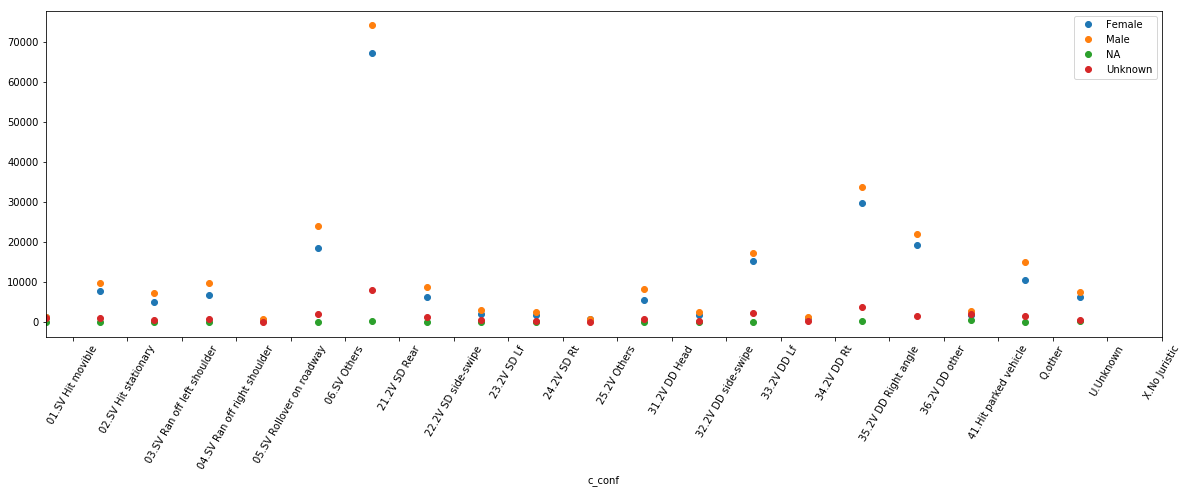

In [62]:
#df2.resample('M').sum().iloc[:,0].sum()

#df2 = df2.resample('M').sum()

df2.plot(style = 'o', figsize = (20,6))

#plt.legend(['1.level straight','2.gradient straight',
#           '3.level curved','4.gradient curved',
#           '5.top hill','6.bottom hill / sag',
#           'other','unknow']);
#df2.resample('M').sum().iloc[:,0].sum()

#xticks(arange(0.5,5.5),mreturn.columns)

plt.legend(['Female','Male','NA','Unknown'])
plt.xticks(np.arange(0.5,21.5),x_lable,rotation=60);

